In [1]:
from graphdatascience import GraphDataScience

host = "bolt://localhost:7687"
user = "neo4j"
password= "sajalali2003"

gds = GraphDataScience(host, auth=(user, password))

print(gds.version())

c:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.12.0


In [13]:
from py2neo import Graph
import pandas as pd

# Connect to Neo4j
graph = Graph("bolt://localhost:7687", auth=("neo4j", "sajalali2003"))

# Query to get the number of papers per author
query = """
MATCH (a:Author)-[:CONTRIBUTED_TO]->(p:Paper)
RETURN a.ID AS author_id, COUNT(DISTINCT p) AS num_papers
"""
num_papers_df = pd.DataFrame(graph.run(query).data())

# Query to get the number of co-authors
query = """
MATCH (a:Author)-[:CONTRIBUTED_TO]->(p:Paper)<-[:CONTRIBUTED_TO]-(coauthor:Author)
WHERE a.ID <> coauthor.ID
RETURN a.ID AS author_id, COUNT(DISTINCT coauthor) AS num_coauthors
"""
num_coauthors_df = pd.DataFrame(graph.run(query).data())

# Query to get the number of topics explained by the author's papers
query = """
MATCH (a:Author)-[:CONTRIBUTED_TO]->(p:Paper)-[:EXPLAINS]->(t:Topic)
RETURN a.ID AS author_id, COUNT(DISTINCT t) AS num_topics_explained
"""
num_topics_df = pd.DataFrame(graph.run(query).data())

# Query to get the number of journals the author has published in
query = """
MATCH (a:Author)-[:CONTRIBUTED_TO]->(p:Paper)-[:IS_IN]->(j:Journal)
RETURN a.ID AS author_id, COUNT(DISTINCT j) AS num_journals
"""
num_journals_df = pd.DataFrame(graph.run(query).data())

# Assuming 'field_of_study' is already part of the data
query = """
MATCH (a:Author)-[:CONTRIBUTED_TO]->(p:Paper)
RETURN a.ID AS author_id, p.`Fields of Study` AS field_of_study
"""
field_of_study_df = pd.DataFrame(graph.run(query).data())

# Merging all data into one DataFrame
df = num_papers_df.merge(num_coauthors_df, on='author_id')
df = df.merge(num_topics_df, on='author_id')
df = df.merge(num_journals_df, on='author_id')
df = df.merge(field_of_study_df, on='author_id')

# Check the merged DataFrame
print(df.head())


    author_id  num_papers  num_coauthors  num_topics_explained  num_journals  \
0  1400383433           8              5                     7             3   
1  1400383433           8              5                     7             3   
2  1400383433           8              5                     7             3   
3  1400383433           8              5                     7             3   
4  1400383433           8              5                     7             3   

      field_of_study  
0  Political Science  
1          Sociology  
2          Economics  
3          Economics  
4  Political Science  


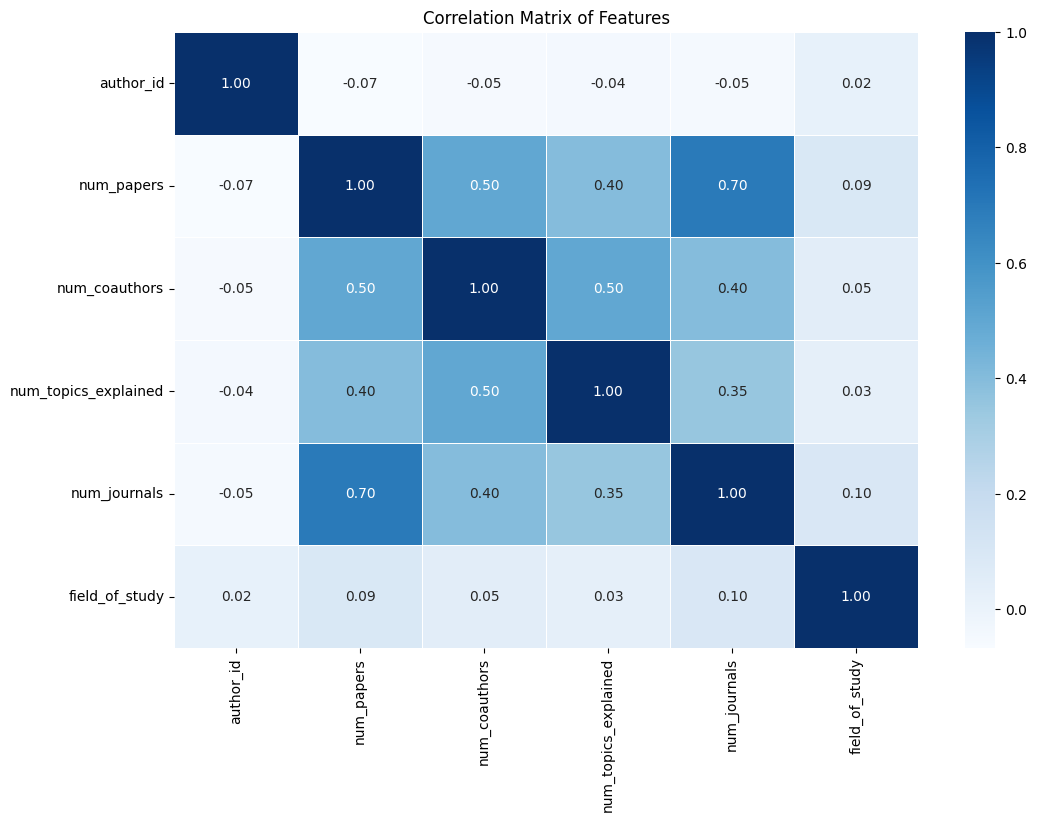

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()


In [15]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target column (field_of_study) to numeric labels
df['field_of_study'] = label_encoder.fit_transform(df['field_of_study'])

# Check the unique numeric labels
print(df['field_of_study'].unique())


[ 65  86  17  30  71  37  93 101  46  95  22  68  76  53   3   9  21   4
  56  70  47  78  97  81  59  62  87   6  33  90  88   0  75  83  31  67
  11  26  42  99  49  89 100  23  84  12  92  16  85  98  39   1  73  15
  61  64  13  24  69  48  36  20  96  19  27  14   5  25  32  18  63  40
  51  77  66   2  91  72  55  54  82  52  44  28  38  43  79  94  74   7
  45  35  34  80  58  29  50   8  60  57  41  10]


In [16]:
# Check for missing values in the dataset
print(df.isnull().sum())

# Optionally, you can drop rows with missing values (if any)
df = df.dropna(subset=['field_of_study'])


author_id               0
num_papers              0
num_coauthors           0
num_topics_explained    0
num_journals            0
field_of_study          0
dtype: int64


In [18]:
df.head()

,author_id,num_papers,num_coauthors,num_topics_explained,num_journals,field_of_study
0,1400383433,8,5,7,3,65
1,1400383433,8,5,7,3,86
2,1400383433,8,5,7,3,17
3,1400383433,8,5,7,3,17
4,1400383433,8,5,7,3,65


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare features (X) and target (y)
X = df.drop(columns=['author_id', 'field_of_study'])  # Drop author_id and target column
y = df['field_of_study']  # Target is the research domain (field of study)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.43762575452716296


In [ ]:
import pandas as pd
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
print(comparison_df.head())



       Actual  Predicted
9387       17         86
19731      81         81
18736      81         53
4420       93         81
1692       17         86


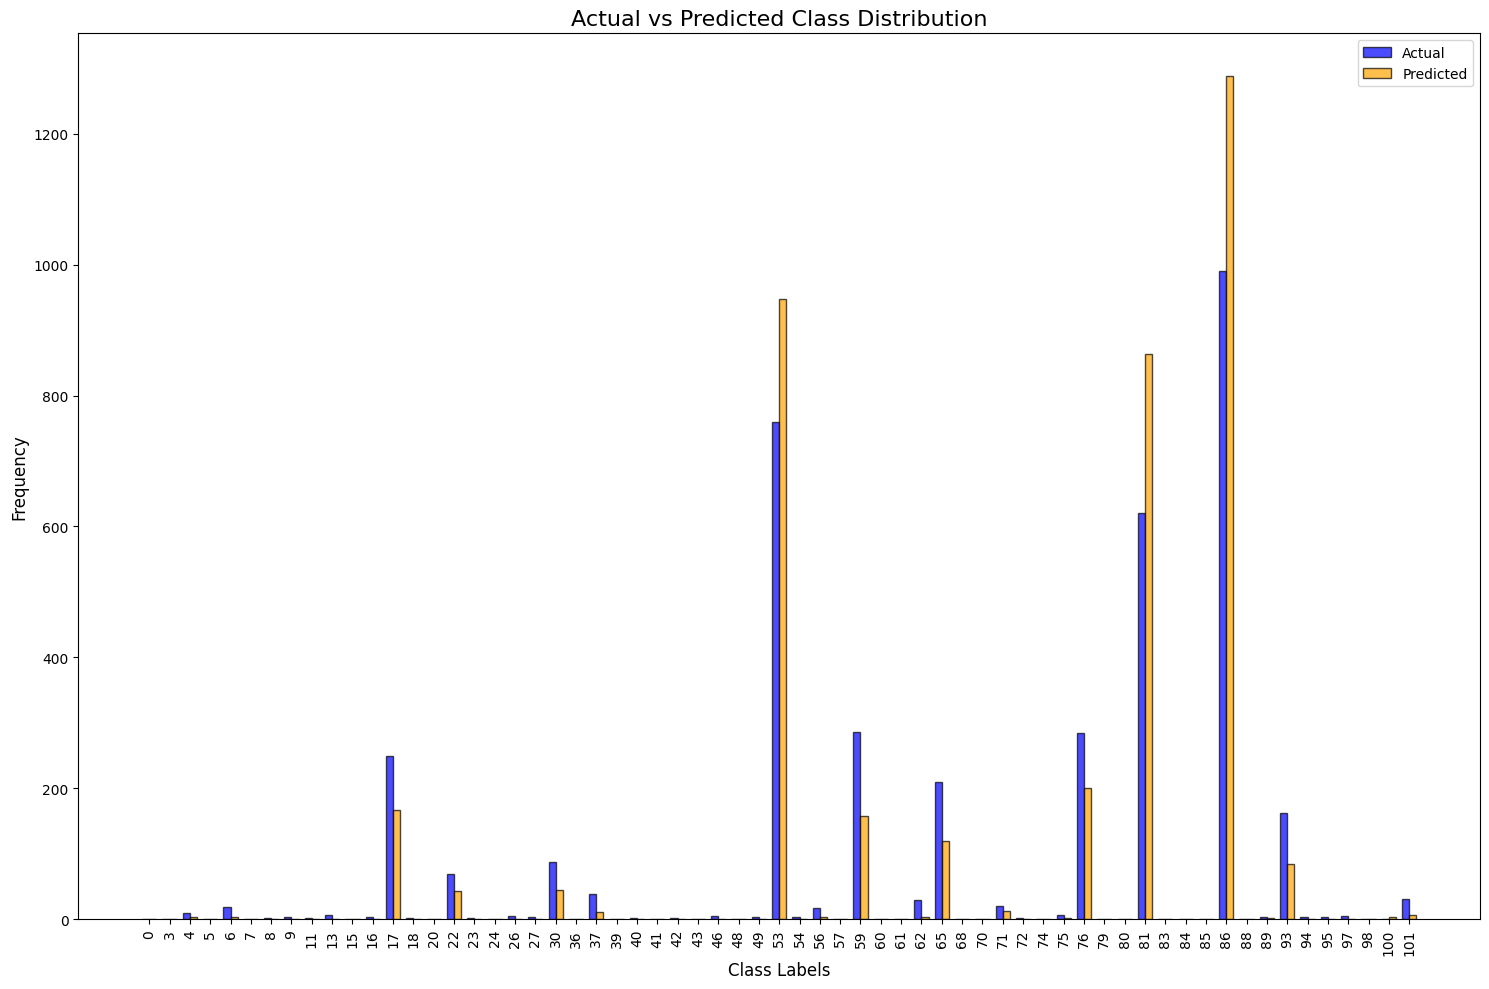

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the plot is large enough to accommodate all classes
plt.figure(figsize=(15, 10))

# Plotting actual vs predicted values for each class using a bar plot
# Count how many times each class appears in the actual vs predicted labels
unique_classes = np.unique(y_test)
actual_counts = [np.sum(y_test == cls) for cls in unique_classes]
predicted_counts = [np.sum(y_pred == cls) for cls in unique_classes]

# Bar plot for Actual vs Predicted class distributions
bar_width = 0.35
index = np.arange(len(unique_classes))

plt.bar(index, actual_counts, bar_width, label='Actual', alpha=0.7, color='blue', edgecolor='black')
plt.bar(index + bar_width, predicted_counts, bar_width, label='Predicted', alpha=0.7, color='orange', edgecolor='black')

# Adding labels and title
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Actual vs Predicted Class Distribution', fontsize=16)

# Rotating the x-axis labels to make them more readable
plt.xticks(index + bar_width / 2, unique_classes, rotation=90, fontsize=10)

# Adding the legend
plt.legend()

# Show the plot
plt.tight_layout()  # Ensure everything fits without overlap
plt.show()


In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multi-class AUC (One-vs-Rest strategy)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

# Calculate AUC score (One-vs-Rest)
auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro', multi_class='ovr')

# Print the AUC score
print(f"AUC Score (One-vs-Rest): {auc:.4f}")


AUC Score (One-vs-Rest): 0.5299
